#  Прогнозирование заказов такси

Построение модели для прогнозирования количества заказов такси в аэропортах в зависимости от времени для привлечения водителей в период пиковой нагрузки. Метрика – RMSE.

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from sklearn.metrics import make_scorer
from datetime import datetime
import time
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

In [2]:
df = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [5]:
print(df.index.is_monotonic)

True


In [6]:
df = df.resample('1H').sum()

### Промежуточные комментарии
Данные загружены, проверены на монотонность, и выполнено ресемплирование медианой по одному часу .

## Анализ

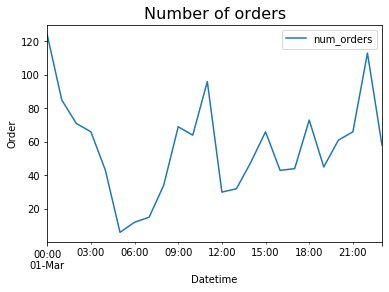

In [7]:
df['2018-03-01':'2018-03-01'].plot()
plt.title('Number of orders', fontsize=16)
plt.xlabel('Datetime')
plt.ylabel('Order')
plt.show()

### Промежуточные комментарии
Как видно из графика чаще всего такси заказывают в ночное время.

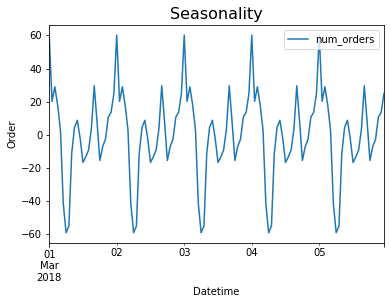

In [8]:
decomposed = seasonal_decompose(df)
decomposed.seasonal['2018-03-01':'2018-03-05'].plot(ax=plt.gca())
plt.title('Seasonality', fontsize=16)
plt.xlabel('Datetime')
plt.ylabel('Order')
plt.show()

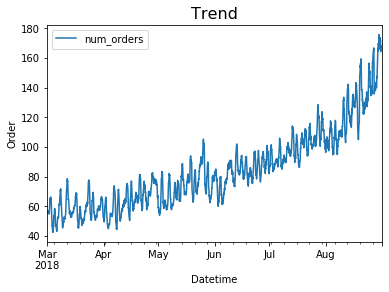

In [9]:
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend', fontsize=16)
plt.xlabel('Datetime')
plt.ylabel('Order')
plt.show()

### Промежуточные комментарии
Из представленных графиков видно, что в летнее время (сезоны отпусков) повышается спрос на такси.
Также подтвердился вывод о том, что чаще вызывают такси в вечернее/ночное время, так как количество общественного транспорта в это время уменьшается, либо у родственников или близких людей нет возможности забрать приезжающих пассажиров.

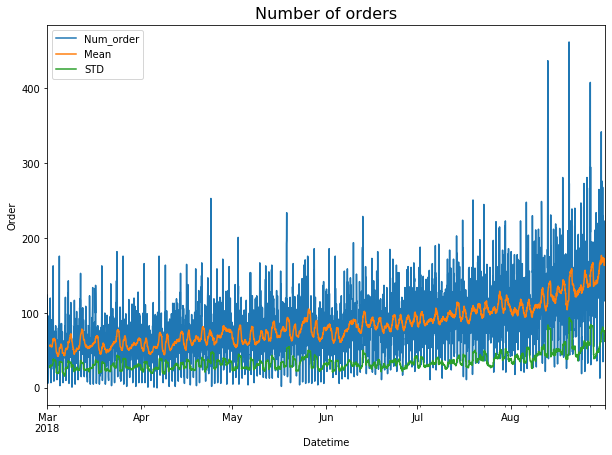

In [10]:
plt.figure(figsize=(10, 7))
df.plot(ax=plt.gca())
df['num_orders'].rolling(24).mean().plot(ax=plt.gca())
df['num_orders'].rolling(24).std().plot(ax=plt.gca())
plt.title('Number of orders', fontsize=16)
plt.xlabel('Datetime')
plt.ylabel('Order')
plt.legend(['Num_order', 'Mean','STD'])
plt.show()

### Промежуточные комментарии
Усреднение по 24 часам сделала временной ряд более стационарным. В следующем действии перед усреднение находится разность временного ряда.

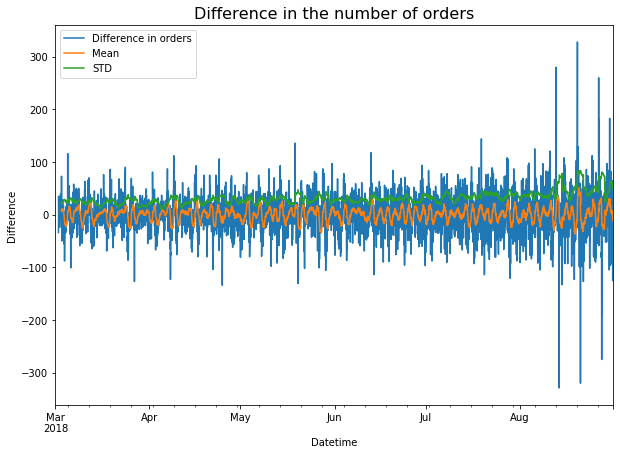

In [11]:
plt.figure(figsize=(10, 7))
(df['num_orders'] - df['num_orders'].shift(24)).plot(ax=plt.gca())
(df['num_orders'] - df['num_orders'].shift(24)).rolling(24).mean().plot(ax=plt.gca())
(df['num_orders'] - df['num_orders'].shift(24)).rolling(24).std().plot(ax=plt.gca())
plt.title('Difference in the number of orders', fontsize=16)
plt.xlabel('Datetime')
plt.ylabel('Difference')
plt.legend(['Difference in orders', 'Mean','STD'])
plt.show()

### Промежуточные комментарии
Из графика видно, что временной ряд стал еще более стационарным. Следовательно, с выбранными параметрами будет произведено прогнозирование.

## Обучение

In [12]:
ROLLING_MEAN_SIZE = 24

In [13]:
df['month'] = df.index.month
df['day'] = df.index.day
df['dayofweek'] = df.index.dayofweek

### Промежуточные комментарии
Добавлены следующие признаки: месяц, день и день недели, так как они могут повлиять на предсказание и его точность.

In [14]:
def make_features(data, max_lag, max_rol):
    ''' Добавление разностей временного ряда '''
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(max_rol).mean()
    data = data.dropna()
    return data

In [15]:
df = make_features(df, 24,ROLLING_MEAN_SIZE)

In [16]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
feauters_train = train.drop('num_orders',axis=1)
target_train = train['num_orders']
feauters_test = test.drop('num_orders',axis=1)
target_test = test['num_orders']

In [17]:
time_split = TimeSeriesSplit(n_splits=3)

In [18]:
def rmse(target, pred):
    """Создание метрики для применения ее в GridSearchCV """
    return (mean_squared_error(target, pred)**0.5)
my_score = make_scorer(rmse, greater_is_better=False)

In [19]:
def predict_data(model,features_test, target_test,name_model):
    """Предсказание и измерение времени """
    start_time = datetime.now()
    pred_test = model.predict(features_test)
    end_time = datetime.now()
    time_predict = end_time - start_time
    rmse_test = rmse(target_test,pred_test)
    print('rmse_test:',round(rmse_test,2))
    print('time_predict:',time_predict)
    plt.figure(figsize=(10, 7))
    target_test.plot(ax=plt.gca())
    ax=plt.gca()
    pd.DataFrame(pred_test,index=target_test.index,columns=["predict"]).plot(ax=plt.gca())
    name = 'Target and predictions of {}'.format(name_model)
    plt.title(name, fontsize=16)
    plt.xlabel('Datetime')
    plt.ylabel('Number of orders')
    plt.legend(['Target', 'Predictions'])
    ax.set_xlim('2018-08-15', '2018-08-17')
    plt.show()
    return rmse_test, time_predict

### Промежуточные комментарии
Данные разделены на обучающую и тестовую выборки. Первые строки с пропущенными значениями в обучающей выборке из-за расчета разностей и скользящего среднего были удалены.
 Также подготовлены функции для повторяющихся действий.

In [20]:
%%time
start_time = datetime.now()
pred_dum = target_test.shift(fill_value=target_train[-1])
end_time = datetime.now()
time_predict_dum = end_time - start_time

CPU times: user 1.38 ms, sys: 0 ns, total: 1.38 ms
Wall time: 1 ms


In [21]:
lr =  LinearRegression()
param_lr = {'normalize':[True,False]}   

In [22]:
%%time
start_time = datetime.now()
model_lr = GridSearchCV(lr, param_lr, refit=True, scoring = my_score, cv=time_split)
best_model_lr = model_lr.fit(feauters_train, target_train)
end_time = datetime.now()
time_gs_lr = end_time - start_time
best_params_lr = best_model_lr.best_params_
print(best_params_lr)

{'normalize': True}
CPU times: user 289 ms, sys: 300 ms, total: 589 ms
Wall time: 573 ms


In [23]:
%%time
start_time = datetime.now()
lr_best =  LinearRegression(normalize = True)
model_lr = lr_best.fit(feauters_train, target_train)
end_time = datetime.now()
time_fit_lr = end_time - start_time

CPU times: user 36.2 ms, sys: 36.7 ms, total: 72.9 ms
Wall time: 97.6 ms


In [24]:
cbr = CatBoostRegressor()
params_cbr = {'depth': [4, 7, 10],
          'learning_rate' : [0.03, 0.1],
          'iterations': [500]}

In [25]:
%%time
start_time = datetime.now()
cbr_model = GridSearchCV(cbr, params_cbr, n_jobs=-1, refit=True,  scoring=my_score, cv = time_split)
best_model_cbr = cbr_model.fit(feauters_train, target_train, verbose=100)
end_time = datetime.now()
time_gs_cbr = end_time - start_time
best_params_cbr = best_model_cbr.best_params_
print(best_params_cbr)

0:	learn: 28.9492418	total: 48.4ms	remaining: 24.2s
100:	learn: 18.2745670	total: 744ms	remaining: 2.94s
200:	learn: 16.5346606	total: 1.5s	remaining: 2.23s
300:	learn: 15.3702623	total: 2.27s	remaining: 1.5s
400:	learn: 14.0701813	total: 3.03s	remaining: 747ms
499:	learn: 13.0351078	total: 3.88s	remaining: 0us
0:	learn: 31.6078788	total: 2.51ms	remaining: 1.25s
100:	learn: 20.3531863	total: 1.17s	remaining: 4.64s
200:	learn: 18.6874219	total: 2.44s	remaining: 3.62s
300:	learn: 17.6548419	total: 3.61s	remaining: 2.39s
400:	learn: 16.7581304	total: 4.87s	remaining: 1.2s
499:	learn: 16.0300514	total: 6.12s	remaining: 0us
0:	learn: 33.5110065	total: 2.16ms	remaining: 1.08s
100:	learn: 22.0766928	total: 1.51s	remaining: 5.96s
200:	learn: 20.6323688	total: 2.98s	remaining: 4.43s
300:	learn: 19.7115765	total: 4.53s	remaining: 2.99s
400:	learn: 18.9569696	total: 5.99s	remaining: 1.48s
499:	learn: 18.2219900	total: 7.47s	remaining: 0us
0:	learn: 28.1396965	total: 1.24ms	remaining: 620ms
100:	l

In [26]:
%%time
start_time = datetime.now()
model_cbr = CatBoostRegressor(loss_function="RMSE", iterations=best_params_cbr['iterations'], 
                        depth = best_params_cbr['depth'], learning_rate = best_params_cbr['learning_rate'],  random_seed=12345)
model_cbr.fit(feauters_train, target_train, verbose=100) 
end_time = datetime.now()
time_fit_cbr = end_time - start_time

0:	learn: 38.1951922	total: 5.41ms	remaining: 2.7s
100:	learn: 23.2794129	total: 4.31s	remaining: 17s
200:	learn: 21.3853825	total: 8.46s	remaining: 12.6s
300:	learn: 19.6690249	total: 12.7s	remaining: 8.41s
400:	learn: 18.2202626	total: 16.9s	remaining: 4.16s
499:	learn: 16.8721310	total: 21.4s	remaining: 0us
CPU times: user 19.4 s, sys: 2.36 s, total: 21.7 s
Wall time: 22.7 s


### Промежуточные комментарии
Были обучены 3 модели с разными гиперпараметрами для дальнейшего выбора наилучшей:
- модель заглушка, где в предсказаниях новых значений используются предыдущие значения ряда;
- линейная регрессия - {'normalize':[True,False]};
- CatBoost - {'depth': [4, 7, 10], 'learning_rate' : [0.03, 0.1], 'iterations': [500]}.

Также в процессе исследования замерялись промежутки времени подбора гиперпараметров, обучения моделей и предсказания.

## Тестирование

In [27]:
rmse_test_dum = mean_squared_error(target_test, pred_dum)
print(rmse_test_dum)

3467.0636363636363


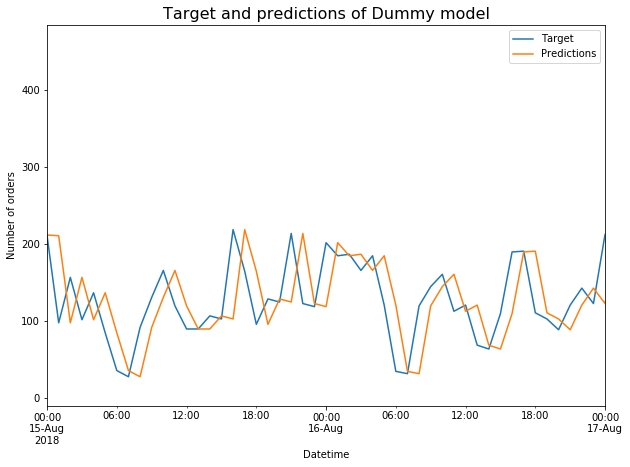

In [28]:
plt.figure(figsize=(10, 7))
target_test.plot(ax=plt.gca())
ax=plt.gca()
pred_dum.plot(ax=plt.gca())
name = 'Target and predictions of {}'.format('Dummy model')
plt.title(name, fontsize=16)
plt.xlabel('Datetime')
plt.ylabel('Number of orders')
plt.legend(['Target', 'Predictions'])
ax.set_xlim('2018-08-15', '2018-08-17')
plt.show()

rmse_test: 45.54
time_predict: 0:00:00.009625


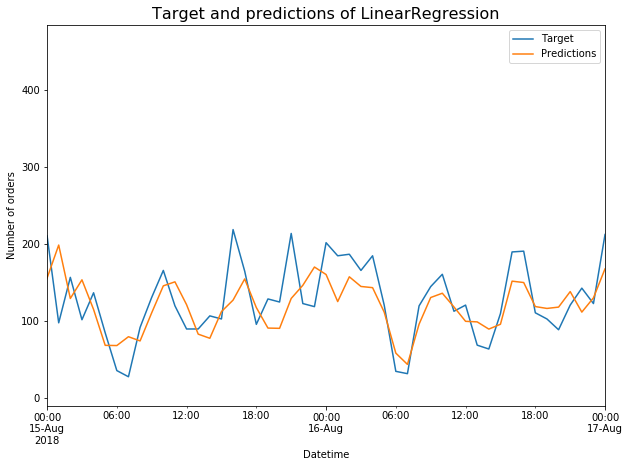

In [29]:
rmse_test_lr, time_predict_lr = predict_data(model_lr,feauters_test, target_test,'LinearRegression')

rmse_test: 42.18
time_predict: 0:00:00.006570


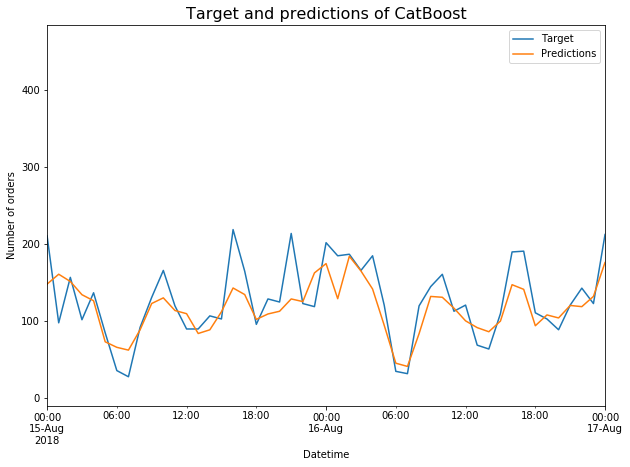

In [30]:
rmse_test_cbr, time_predict_cbr = predict_data(model_cbr,feauters_test, target_test,'CatBoost')

In [31]:
res_all = np.array([['Dummy', 'None', round(rmse_test_dum,2),'-','-',time_predict_dum],
                    ['LinearRegression', best_params_lr, round(rmse_test_lr,2),time_gs_lr,time_fit_lr,time_predict_lr],
                   ['CatBoost', best_params_cbr, round(rmse_test_cbr,2),time_gs_cbr,time_fit_cbr,time_predict_cbr]])
result_all = pd.DataFrame(res_all,columns = ['model', 'parameters', 'rmse','time_gs','time_fit','time_predict'])

In [32]:
result_all

,model,parameters,rmse,time_gs,time_fit,time_predict
0,Dummy,None,3467.06,00:00:00,00:00:00,00:00:00.000961
1,LinearRegression,{'normalize': True},45.54,00:00:00.573111,00:00:00.097531,00:00:00.009625
2,CatBoost,"{'depth': 7, 'iterations': 500, 'learning_rate...",42.18,00:09:09.966533,00:00:22.743014,00:00:00.006570


## Выводы
В результате предсказания с помощью моделей с подобранными гиперпараметрами RMSE на тестовой выборке получилось:
- model_dummy: 3467;
- LinearRegression: 45.54;
- CatBoost: 42.18.

Согласно произведенным исследованиям компании «Чётенькое такси» для предсказания количества заказов такси предлагается использовать модель LinearRegression, хотя RMSE на 3.3 хуже чем у модели CatBoost, но модель линейной регрессии обучается и предсказывает быстрее.